# Training BERT Base for Systematic Math Equations from Scratch¶

In [1]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('C:/Users/lenna/Documents/UvA/DL2/dl2-callibrated-lm/dataset/math_dataset_1_to_10_+_-_ .csv') 

data['combined'] = data['Equation'] + data['Answer'].astype(str) 
data_list = data['combined'].tolist().copy()
data_train, data_val = train_test_split(data_list, test_size=0.25)
data_val, data_test = train_test_split(data_val, test_size=0.5)
print(len(data_train))

15000


# Tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# VOCAB_SIZE = 1000
# TOKENIZER_PATH = '/kaggle/working/tokenizer/'
# 
# tokenizer = Tokenizer(BPE())
# tokenizer.pre_tokenizer = Whitespace()
# tokenizer.decoder = ByteLevel()
# trainer = BpeTrainer(vocab_size=VOCAB_SIZE, 
#                      special_tokens=["<s>","<pad>","</s>","<unk>","<mask>"]) # inital_alphabet=ByteLevel.alphabet()
# 
# tokenizer.train_from_iterator(data_list, trainer)
# 
# if not os.path.exists(TOKENIZER_PATH):
#     os.makedirs(TOKENIZER_PATH)
# tokenizer.model.save(TOKENIZER_PATH)

# Dataset & Model Setup

In [5]:
N_EPOCH = 5
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
LEARNING_RATE = 3e-5
MODEL_NAME = 'bert_math_1'

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=64,
    type_vocab_size=1,
    initializer_range=0.02
)

In [6]:
class BertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.padding = 'max_length'
        self.data = df # df['sentences'].to_list()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = self.tokenizer(self.data, padding=self.padding, truncation=True, 
                                        max_length=self.max_length, return_tensors='pt')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].detach().clone()
        return item

def model_predict(sentence_list, printer=False, top_k=5):
    n_correct = 0
    n_correct_top_k = 0
    true_labels = []
    eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
    
    # randomly masking tokens in each sentence
    for i in range(eval_tokenized['input_ids'].shape[0]):
        n_tokens = sum(eval_tokenized['attention_mask'][i])
        random_mask_idx = random.randint(1,n_tokens-2) # eliminating start & end tokens 
        true_token = eval_tokenized['input_ids'][i, random_mask_idx].item()
        true_labels += [true_token]
        eval_tokenized['input_ids'][i, random_mask_idx] = tokenizer.mask_token_id

    model.eval()
    with torch.no_grad():
        eval_outputs = model(**eval_tokenized.to(device))
    
    eval_logits = eval_outputs['logits']
    for i in range(len(sentence_list)):
        mask_idx = torch.where(eval_tokenized['input_ids'][i]==tokenizer.mask_token_id)[0].item()
        eval_probs = torch.topk(F.softmax(eval_logits[i, mask_idx, :],dim=0), top_k).values    
        eval_preds = torch.topk(eval_logits[i, mask_idx, :], top_k).indices
        eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)
    
        if(eval_preds[0].item()==true_labels[i]):
            n_correct += 1
        if(true_labels[i] in eval_preds.tolist()):
            n_correct_top_k += 1
        if(printer):
            print(f"[{i}] SENTENCE.........:", sentence_list[i])
            print(f"[{i}] MASKED TOKEN.....:", tokenizer.convert_ids_to_tokens(true_labels[i]))
            print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
            print(f"[{i}] CONFIDENCE:......:", [round(x, 2) for x in eval_probs.tolist()], '\n')
    print('ACCURACY.............:', round(n_correct/len(sentence_list),2))
    print(f"ACCURACY TOP {top_k}.......:", round(n_correct_top_k/len(sentence_list),2))
    return (n_correct/len(sentence_list), round(n_correct_top_k/len(sentence_list),2))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = BertDataset(data_train, tokenizer)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.2)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

model = BertForMaskedLM(config=config).to(device) # BERT()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print('model n_parameters:', model.num_parameters())

cuda
model n_parameters: 109169466


# Model Training

In [35]:
# val_set = random.sample(data_list, 2000)
def train_model(model):
    training_loss = []
    training_acc = []
    training_acc_k = []
    lowest_loss = 999

    model.train()
    for epoch in range(N_EPOCH):
        total_loss = 0.0
        for step, batch in enumerate(tqdm(data_loader)):
            model.zero_grad()
            outputs = model(**batch.to(device))
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"epoch [{epoch+1}/{N_EPOCH}] avg loss: {total_loss/len(data_loader):.4f}")
        training_loss += [total_loss/len(data_loader)]
        (acc_1, acc_2),_,_,_ = model_predict(data_val, top_k=3)
        training_acc += [acc_1]
        training_acc_k += [acc_2]
        if ((total_loss/len(data_loader))<lowest_loss):
            torch.save(model.state_dict(), f"{MODEL_NAME}.pth")
            lowest_loss = total_loss/len(data_loader)
            print(f"> > model is saved at epoch {epoch+1} with the loss of {round(lowest_loss,4)}.")

    return model\
    
model = train_model(model)

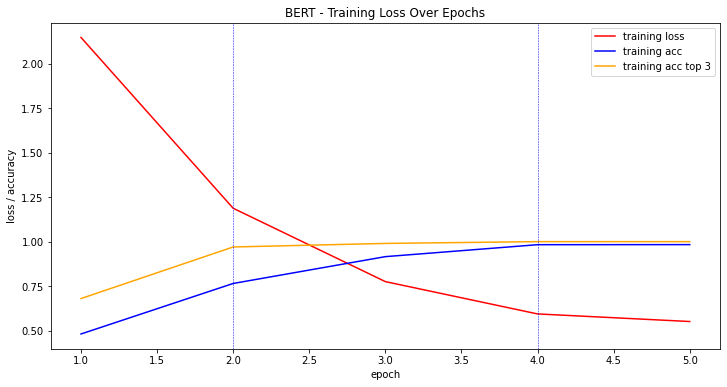

In [37]:
x_axis = list(range(1, 6))
plt.figure(figsize=(12, 6))
plt.plot(x_axis, training_loss, color='r', label='training loss')
plt.plot(x_axis, training_acc, color='b', label='training acc')
plt.plot(x_axis, training_acc_k, color='orange', label='training acc top 3')
[plt.axvline(x=_x, ls='--', lw=0.5, c='b') for _x in range(2,5,2)]
plt.title('BERT - Training Loss Over Epochs')
plt.xlabel('epoch')
plt.ylabel('loss / accuracy')
plt.legend(loc='upper right')
plt.savefig(f"{MODEL_NAME}.png", bbox_inches='tight')
plt.show();

# Model Evaluation

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=64,
    type_vocab_size=1,
    initializer_range=0.02
)

model = BertForMaskedLM(config=config).to(device)
model.load_state_dict(torch.load('C:/Users/lenna/Documents/UvA/DL2/dl2-callibrated-lm/BERT/bert_math_1.pth'))

cuda


<All keys matched successfully>

In [10]:
(acc, acc_top_5), true_labels = model_predict(data_test, top_k=5, printer=True)

[0] SENTENCE.........: 10 * 5 = 50
[0] MASKED TOKEN.....: 10
[0] TOP 5 MODEL PREDS: ['10', '9', '1', '8', '5']
[0] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[1] SENTENCE.........: 1 + 2 = 3
[1] MASKED TOKEN.....: +
[1] TOP 5 MODEL PREDS: ['+', '*', '-', '9', '21']
[1] CONFIDENCE:......: [0.97, 0.02, 0.0, 0.0, 0.0] 

[2] SENTENCE.........: 6 - 1 = 5
[2] MASKED TOKEN.....: =
[2] TOP 5 MODEL PREDS: ['=', '10', '0', '18', '20']
[2] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[3] SENTENCE.........: 4 * 9 = 36
[3] MASKED TOKEN.....: 9
[3] TOP 5 MODEL PREDS: ['9', '6', '10', '7', '3']
[3] CONFIDENCE:......: [0.98, 0.01, 0.0, 0.0, 0.0] 

[4] SENTENCE.........: 3 + 3 = 6
[4] MASKED TOKEN.....: 3
[4] TOP 5 MODEL PREDS: ['3', '5', '1', '4', '9']
[4] CONFIDENCE:......: [0.99, 0.0, 0.0, 0.0, 0.0] 

[5] SENTENCE.........: 1 - 10 = -9
[5] MASKED TOKEN.....: 10
[5] TOP 5 MODEL PREDS: ['10', '9', '1', '11', '8']
[5] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[6] SENTENCE.........: 4 + 10 = 

(0.9832, 1.0)

### closeness measures

In [9]:
def model_predict(sentence_list, printer=False, top_k=5):
    n_correct = 0
    n_correct_top_k = 0
    true_labels = []
    eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
    
    # randomly masking tokens in each sentence
    for i in range(eval_tokenized['input_ids'].shape[0]):
        n_tokens = sum(eval_tokenized['attention_mask'][i])
        random_mask_idx = random.randint(1,n_tokens-2) # eliminating start & end tokens 
        true_token = eval_tokenized['input_ids'][i, random_mask_idx].item()
        true_labels += [true_token]
        eval_tokenized['input_ids'][i, random_mask_idx] = tokenizer.mask_token_id

    model.eval()
    with torch.no_grad():
        eval_outputs = model(**eval_tokenized.to(device))

    pred_labels = []
    confidences = []
    eval_logits = eval_outputs['logits']
    for i in range(len(sentence_list)):
        mask_idx = torch.where(eval_tokenized['input_ids'][i]==tokenizer.mask_token_id)[0].item()
        eval_probs = torch.topk(F.softmax(eval_logits[i, mask_idx, :],dim=0), top_k).values    
        eval_preds = torch.topk(eval_logits[i, mask_idx, :], top_k).indices
        eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)
        pred_labels.append(eval_preds[0].item())
        confidences.append(round(eval_probs.tolist()[0],2))

        if(eval_preds[0].item()==true_labels[i]):
            n_correct += 1
        if(true_labels[i] in eval_preds.tolist()):
            n_correct_top_k += 1
        if(printer):
            print(f"[{i}] SENTENCE.........:", sentence_list[i])
            print(f"[{i}] MASKED TOKEN.....:", tokenizer.convert_ids_to_tokens(true_labels[i]))
            print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
            print(f"[{i}] CONFIDENCE:......:", [round(x, 2) for x in eval_probs.tolist()], '\n')
    print('ACCURACY.............:', round(n_correct/len(sentence_list),2))
    print(f"ACCURACY TOP {top_k}.......:", round(n_correct_top_k/len(sentence_list),2))
    return (n_correct/len(sentence_list), round(n_correct_top_k/len(sentence_list),2)), np.array(true_labels), np.array(pred_labels), np.array(confidences)

Check calibration

In [10]:
(acc, acc_top_5), true_labels, pred_labels, confidences = model_predict(data_val, top_k=5, printer=False)

ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


c:\Users\lenna\Documents\UvA\DL2\dl2-callibrated-lm\BERT\reliability_diagrams.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


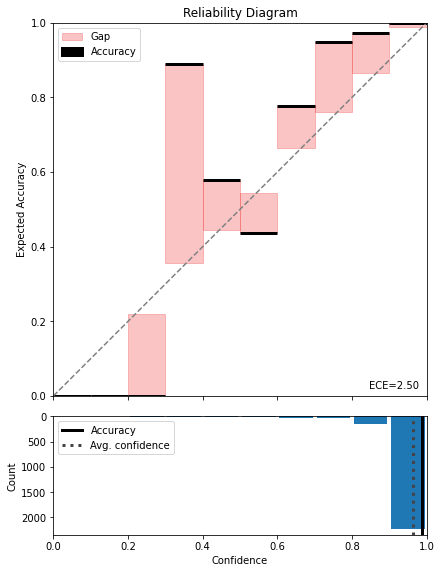

In [11]:
from reliability_diagrams import *

reliability_diagram(true_labels, pred_labels, confidences)

Calibrate

C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


TEMPERATURE:	 0.5
ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


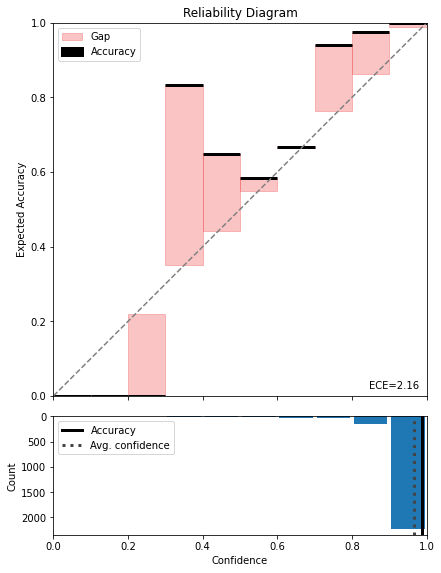

TEMPERATURE:	 0.75


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


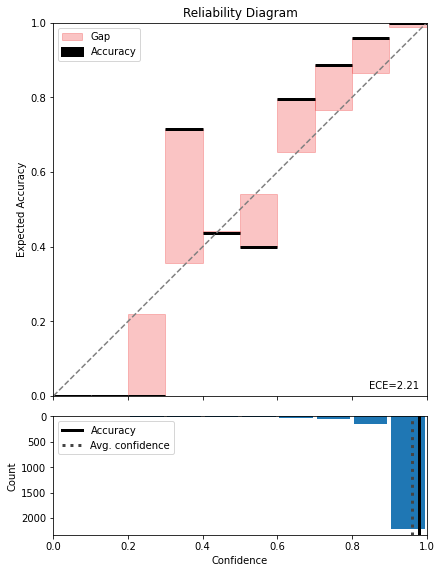

TEMPERATURE:	 0.9


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


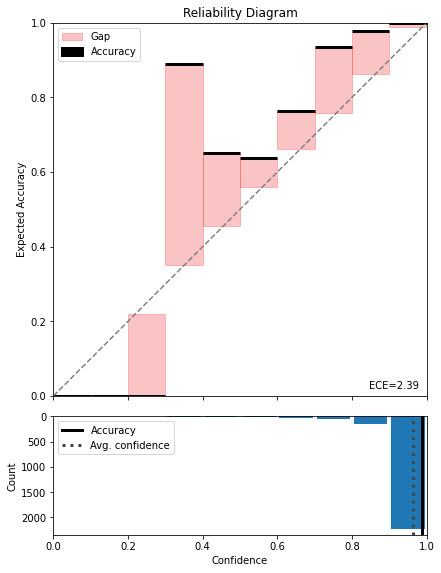

TEMPERATURE:	 0.95


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


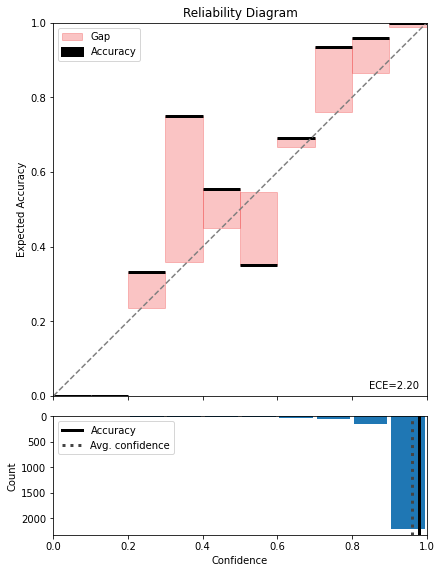

TEMPERATURE:	 1.1


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


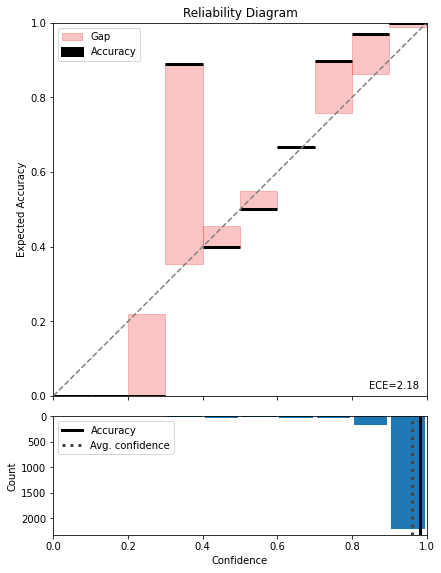

TEMPERATURE:	 1.2


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


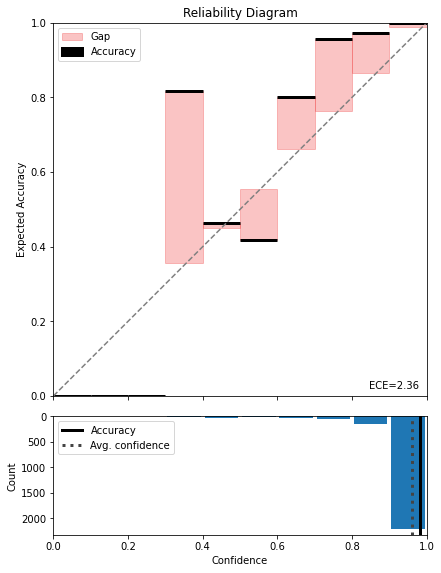

TEMPERATURE:	 1.3


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


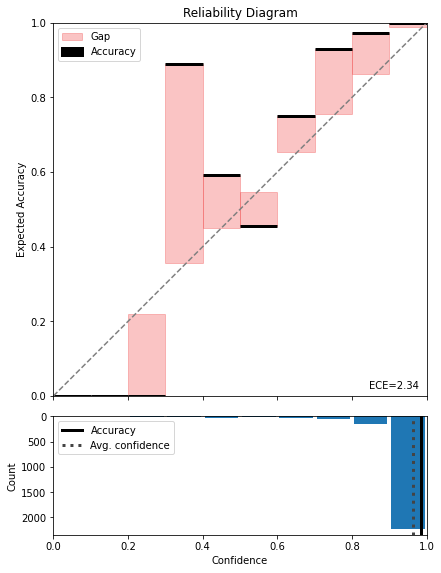

TEMPERATURE:	 1.4


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


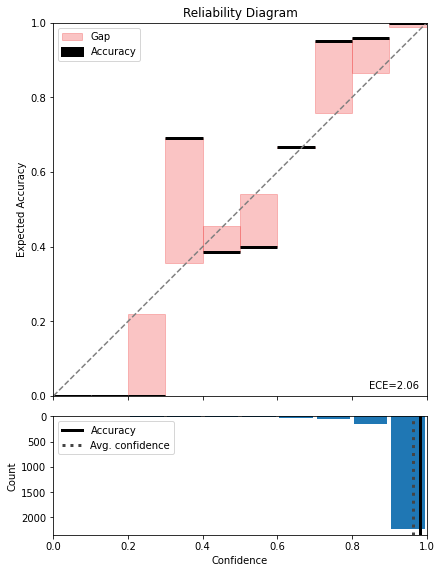

TEMPERATURE:	 1.5


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


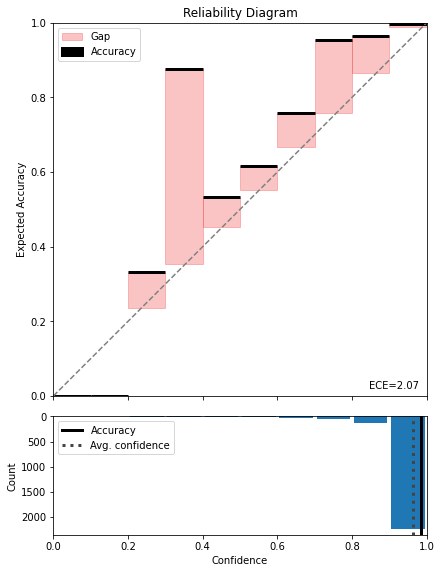

TEMPERATURE:	 2


C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


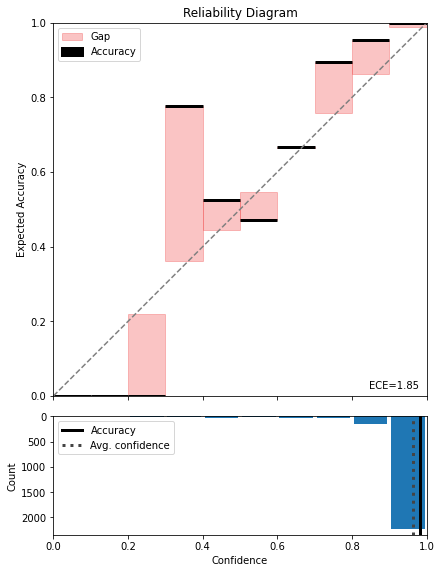

In [12]:
for temp in [0.5, 0.75, 0.9, 0.95, 1.1, 1.2, 1.3, 1.4, 1.5, 2]:
    print(f"TEMPERATURE:\t {temp}")
    config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=64,
        type_vocab_size=1,
        initializer_range=0.02,
        temperature=temp
    )

    model = BertForMaskedLM(config=config).to(device)
    model.load_state_dict(torch.load('C:/Users/lenna/Documents/UvA/DL2/dl2-callibrated-lm/BERT/bert_math_1.pth'))

    (acc, acc_top_5), true_labels, pred_labels, confidences = model_predict(data_val, top_k=5, printer=False)
    reliability_diagram(true_labels, pred_labels, confidences)

Label smoothing:	 0.5
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


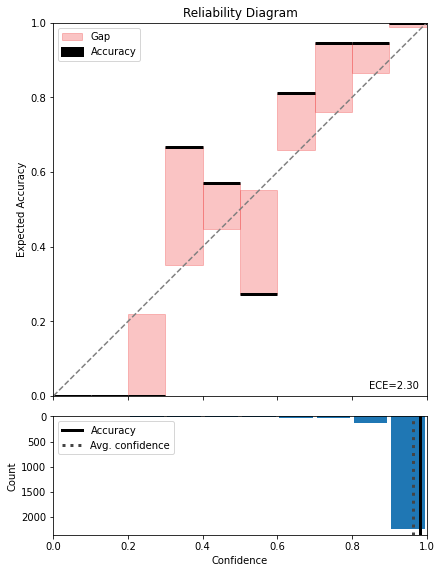

Label smoothing:	 0.75
ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


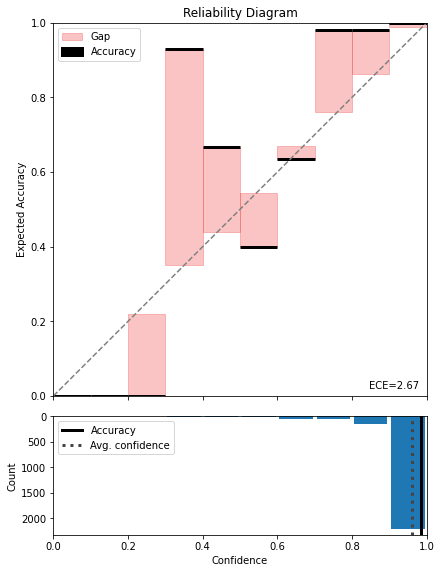

Label smoothing:	 0.9
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


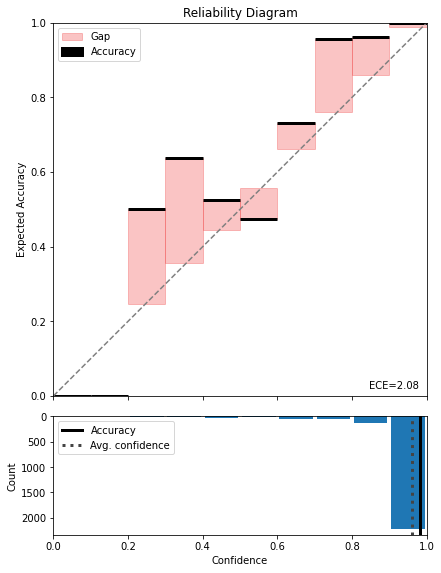

Label smoothing:	 0.95
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


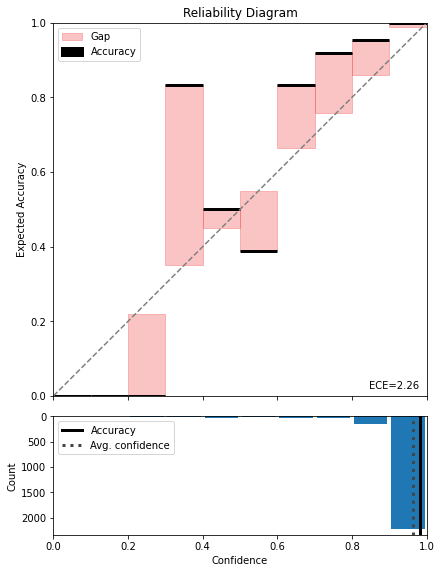

Label smoothing:	 1.1
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


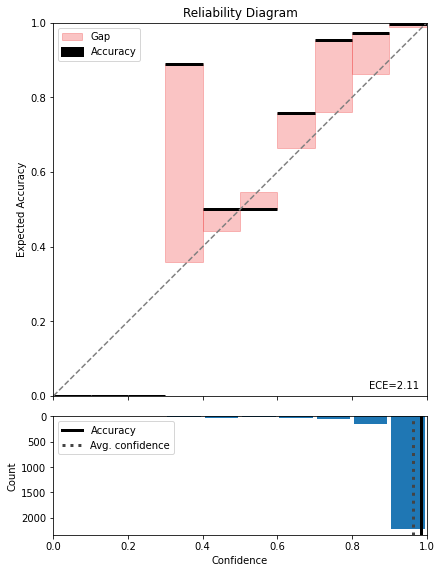

Label smoothing:	 1.2
ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


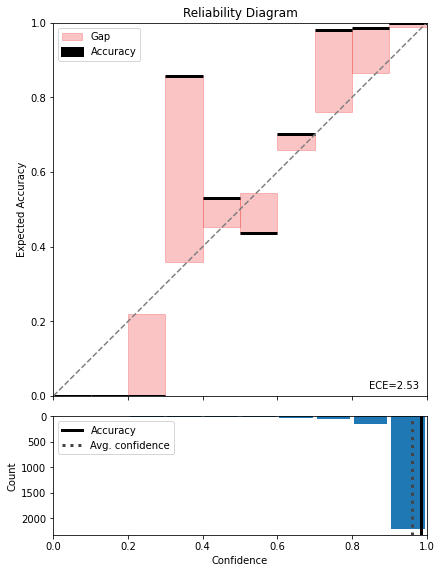

Label smoothing:	 1.3
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


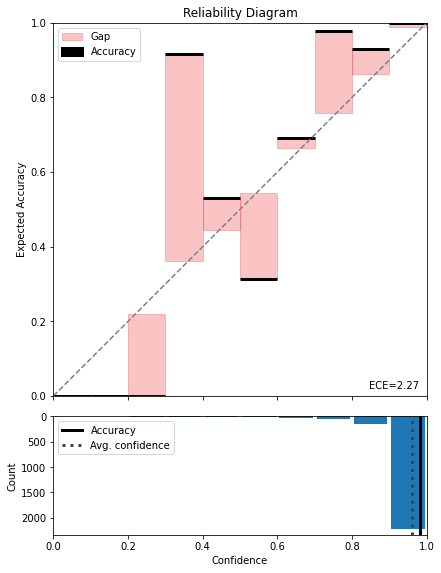

Label smoothing:	 1.4
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


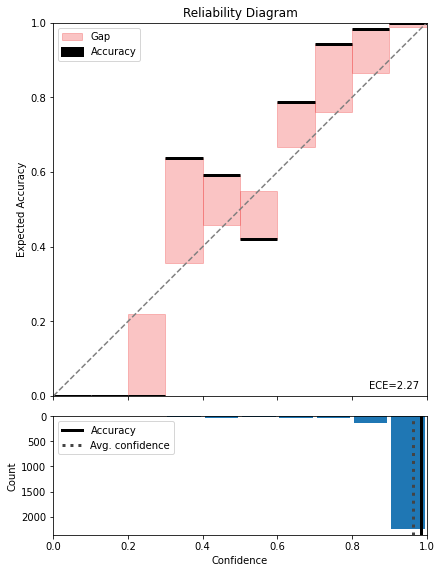

Label smoothing:	 1.5
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


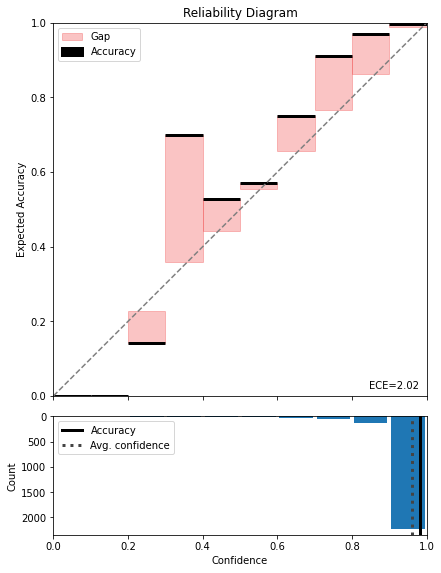

Label smoothing:	 2
ACCURACY.............: 0.98
ACCURACY TOP 5.......: 1.0


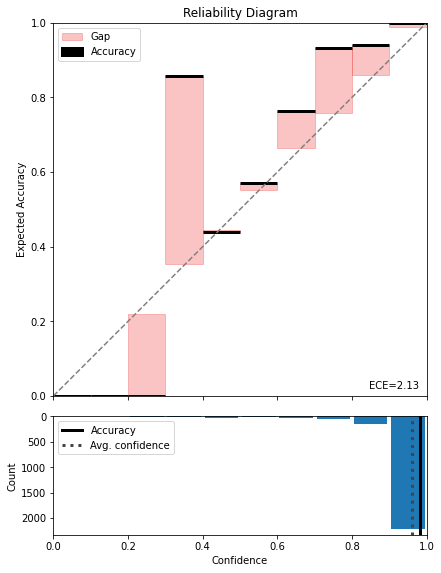

In [13]:
for ls in [0.5, 0.75, 0.9, 0.95, 1.1, 1.2, 1.3, 1.4, 1.5, 2]:
    print(f"Label smoothing:\t {ls}")
    config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=64,
        type_vocab_size=1,
        initializer_range=0.02,
        label_smoothing_factor=ls
    )

    model = BertForMaskedLM(config=config).to(device)
    model.load_state_dict(torch.load('C:/Users/lenna/Documents/UvA/DL2/dl2-callibrated-lm/BERT/bert_math_1.pth'))

    (acc, acc_top_5), true_labels, pred_labels, confidences = model_predict(data_val, top_k=5, printer=False)
    reliability_diagram(true_labels, pred_labels, confidences)

C:\Users\lenna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


ACCURACY.............: 0.99
ACCURACY TOP 5.......: 1.0


c:\Users\lenna\Documents\UvA\DL2\dl2-callibrated-lm\BERT\reliability_diagrams.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


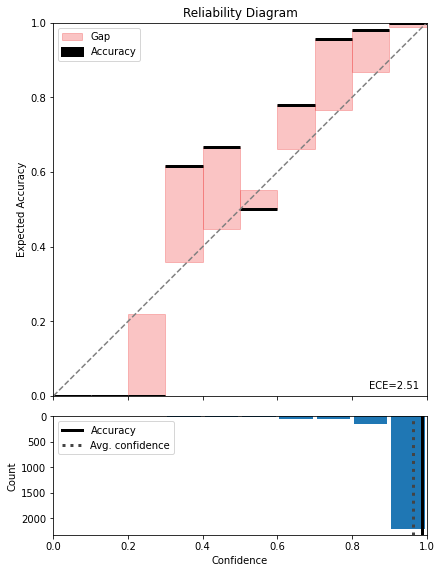

In [16]:
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=64,
    type_vocab_size=1,
    initializer_range=0.02,
    label_smoothing_factor=1.5,
    temperature=1.4
)

model = BertForMaskedLM(config=config).to(device)
model.load_state_dict(torch.load('C:/Users/lenna/Documents/UvA/DL2/dl2-callibrated-lm/BERT/bert_math_1.pth'))

(acc, acc_top_5), true_labels, pred_labels, confidences = model_predict(data_val, top_k=5, printer=False)
reliability_diagram(true_labels, pred_labels, confidences)

check hallucinations of calibrated model

In [18]:
(acc, acc_top_5), true_labels,_,_ = model_predict(data_test, top_k=5, printer=True)

[0] SENTENCE.........: 9 - 7 = 2
[0] MASKED TOKEN.....: 7
[0] TOP 5 MODEL PREDS: ['7', '5', '9', '6', '8']
[0] CONFIDENCE:......: [0.99, 0.0, 0.0, 0.0, 0.0] 

[1] SENTENCE.........: 4 + 7 = 11
[1] MASKED TOKEN.....: =
[1] TOP 5 MODEL PREDS: ['=', '10', '12', '15', '18']
[1] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[2] SENTENCE.........: 4 + 6 = 10
[2] MASKED TOKEN.....: +
[2] TOP 5 MODEL PREDS: ['+', '*', '2', '70', '-']
[2] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[3] SENTENCE.........: 2 * 4 = 8
[3] MASKED TOKEN.....: 4
[3] TOP 5 MODEL PREDS: ['4', '6', '2', '8', '10']
[3] CONFIDENCE:......: [0.98, 0.01, 0.0, 0.0, 0.0] 

[4] SENTENCE.........: 8 * 6 = 48
[4] MASKED TOKEN.....: =
[4] TOP 5 MODEL PREDS: ['=', '3', '15', '10', '7']
[4] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[5] SENTENCE.........: 7 + 7 = 14
[5] MASKED TOKEN.....: 7
[5] TOP 5 MODEL PREDS: ['7', '5', '6', '9', '2']
[5] CONFIDENCE:......: [0.86, 0.07, 0.05, 0.01, 0.0] 

[6] SENTENCE.........: 3 - 5 = -2